## Final Project - Reveal AI

In [ ]:
# from google.colab import files
# files.upload()
!pip install timm
# Path to the ZIP file on Google Drive (replace if your path is different)
# DRIVE_ZIP_PATH = '/content/drive/MyDrive/data.zip'

# # Local temporary disk destination
# LOCAL_DESTINATION = '/content/'

# # Execute the copy command
# !cp "{DRIVE_ZIP_PATH}" "{LOCAL_DESTINATION}"

# print(f" Copied {DRIVE_ZIP_PATH} to local Colab disk.")
# # Path to the ZIP file on the local disk
# LOCAL_ZIP_PATH = '/content/data.zip'

# # Execute the unzip command
# # -q: quiet (less terminal output)
# # -d /content/: extract contents to the /content/ directory
# !unzip -q "{LOCAL_ZIP_PATH}" -d /content/

# print(" Unzipping complete! Your data is now fast to access.")
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# imports
import os, sys,torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
import torch
import torch.nn.functional as F
import timm
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
# !unzip data.zip -d .

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
size_check = {}
# verify that the images are the same size or not
# print(os.listdir('1_fake')[0:10])
for img in os.listdir('/content/data/1_fake'):
    if '.ipynb_checkpoints' == img:
        continue
    images=Image.open('/content/data/1_fake/'+img)
    # print(images.size)
    if images.size in size_check:
        size_check[images.size] += 1
    else:
        size_check[images.size] = 1
print(list(size_check.items())[0:10])


In [ ]:
size_check = {}
# verify that the images are the same size or not
# print(os.listdir('1_fake')[0:10])
for img in os.listdir('/content/data/0_real'):
    if '.ipynb_checkpoints' == img:
        continue
    images=Image.open('/content/data/0_real/'+img)
    # print(images.size)
    if images.size in size_check:
        size_check[images.size] += 1
    else:
        size_check[images.size] = 1
print(list(size_check.items())[0:10])


In [ ]:
# Resize images for convnext
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Classes: {dataset.classes}")
print(f"Total images: {len(dataset)}")

In [ ]:

model = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

print("Model ready on device:", device)

In [ ]:


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
for epoch in range(10):
    total, correct, running_loss = 0, 0, 0
    model.train()

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss={running_loss/len(dataloader):.4f}, Acc={acc:.2f}%")

Epoch 1: Loss=0.2053, Acc=92.07%
Epoch 2: Loss=0.0688, Acc=97.61%
Epoch 3: Loss=0.0302, Acc=98.89%
Epoch 4: Loss=0.0260, Acc=99.09%
Epoch 5: Loss=0.0197, Acc=99.31%
Epoch 6: Loss=0.0174, Acc=99.37%
Epoch 7: Loss=0.0105, Acc=99.60%
Epoch 8: Loss=0.0106, Acc=99.65%
Epoch 9: Loss=0.0046, Acc=99.85%
Epoch 10: Loss=0.0072, Acc=99.79%


Predicted class: 1_fake


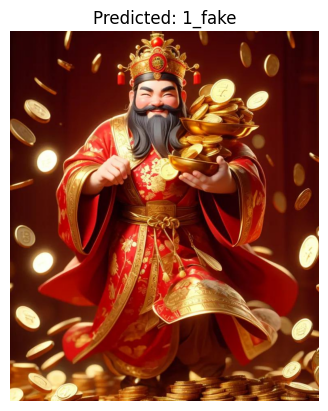

In [ ]:
# random image from fake set
img_path = '/content/data/1_fake/0ac485de-d5f7-4ee5-a620-354b6b766314.jpg'

# same transform as training
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert("RGB")
x = tf(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred = model(x).argmax(1).item()

label_names = dataset.classes
print("Predicted class:", label_names[pred])

plt.imshow(img)
plt.title(f"Predicted: {label_names[pred]}")
plt.axis("off")
plt.show()